In [20]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scipy.stats as stats

# check out https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.errorbar.html#matplotlib.axes.Axes.errorbar
# for plot of numerous experiments with same settings

exp_path = "experiments/" + "standard"
if os.path.isfile(
        exp_path + "/simulated_data_shortage_output.csv"):  # check whether we have just a single experiment, or a collection 
    data = [pd.read_csv(exp_path + "/simulated_data_shortage_output.csv")]
else:
    data = [pd.read_csv(exp_path + "/" + path + "/simulated_data_shortage_output.csv") for path in
            os.listdir(exp_path + "/")]

In [21]:
disc_performances = [[float(number[7:-1]) for number in sample["optic_disc_performance"]] for sample in data]
cup_performances = [[float(number[7:-1]) for number in sample["optic_cup_performance"]] for sample in data]
percentages = [round(float(perc), 3) for perc in
               data[0]["percentage"]]  # assuming that all experiments were run with the same percentages

In [22]:
disc_performances = np.array(disc_performances)
cup_performances = np.array(cup_performances)

In [23]:
summary_frame = pd.DataFrame(
    np.array([percentages, disc_performances.mean(axis=0), disc_performances.std(axis=0), cup_performances.mean(axis=0),
              cup_performances.std(axis=0)]).T,
    columns=["percentages", "disc_performance_mean", "disc_performance_std", "cup_performance_mean",
             "cup_performance_std"]
)
summary_frame.to_csv(exp_path + "/summary.csv")

In [24]:
disc_performances.mean(axis=0)

array([0.91895385, 0.91866923, 0.91954615, 0.91997692, 0.92044615,
       0.91946154, 0.92199231, 0.92035385, 0.92290769, 0.92303846])

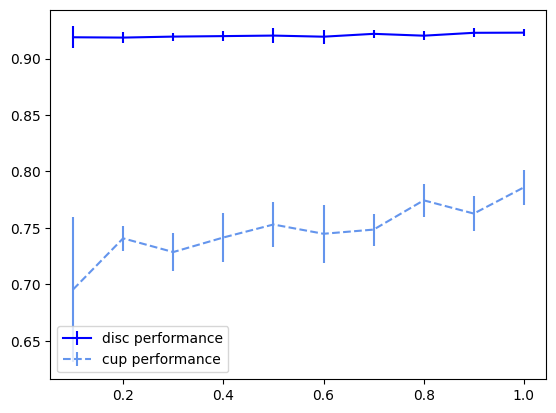

In [25]:
alpha = 0.05  # alpha level for confidence intervals

plt.errorbar(percentages,
             disc_performances.mean(axis=0),
             yerr=stats.t.ppf(1 - alpha / 2, df=(len(data) - 1)) / (len(data) ** (1 / 2)) * disc_performances.std(
                 axis=0),
             linestyle="-", color="b", label="disc performance")
plt.errorbar(percentages,
             cup_performances.mean(axis=0),
             yerr=stats.t.ppf(1 - alpha / 2, df=(len(data) - 1)) / (len(data) ** (1 / 2)) * cup_performances.std(
                 axis=0),
             linestyle="--", color="cornflowerblue", label="cup performance")
# plt.plot(percentages, disc_performance, linestyle="-", color="b", label="disc performance")
# plt.plot(percentages, cup_performance, linestyle="--", color="b", label="cup performance")
plt.legend()

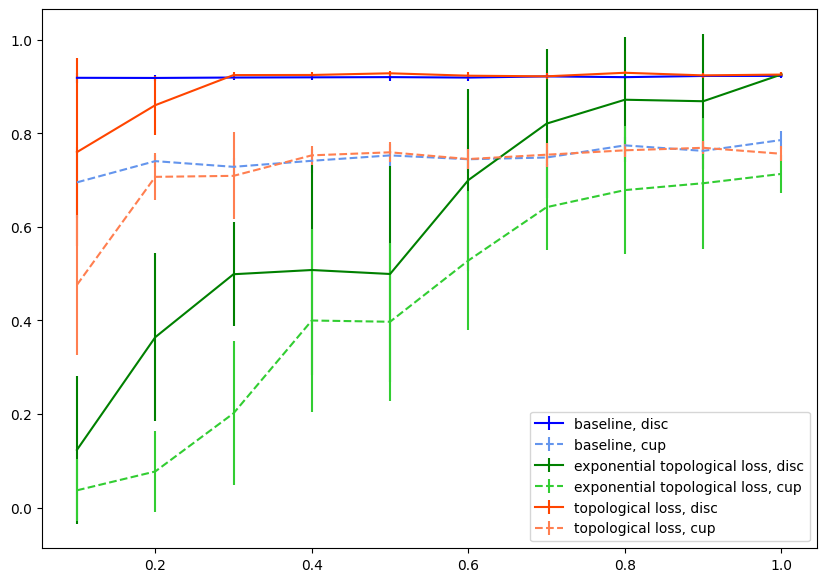

In [33]:
experiments_of_interest = ["standard", "exp_top", "topological"]
experiments_labels = ["baseline", "exponential topological loss", "topological loss"]
experiments_colors = [("b", "cornflowerblue"), ("green", "limegreen"), ("orangered", "coral")]
exp_paths = ["experiments/" + name for name in experiments_of_interest]

plt.rcParams["figure.figsize"] = (10,7)

for i in range(len(experiments_of_interest)):
    data = pd.read_csv(exp_paths[i] + "/summary.csv")
    plt.errorbar(data["percentages"],
                 data["disc_performance_mean"],
                 yerr=stats.t.ppf(1 - alpha / 2, df=(len(data) - 1)) / (len(data) ** (1 / 2)) * data["disc_performance_std"],
                 linestyle="-", color=experiments_colors[i][0], label=experiments_labels[i] + ", disc")
    plt.errorbar(data["percentages"],
                 data["cup_performance_mean"],
                 yerr=stats.t.ppf(1 - alpha / 2, df=(len(data) - 1)) / (len(data) ** (1 / 2)) * data["cup_performance_std"],
                 linestyle="--", color=experiments_colors[i][1], label=experiments_labels[i] + ", cup")
plt.legend()
plt.show()